In [1]:
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import ddsp_textures.auxiliar.filterbanks
import ddsp_textures.auxiliar.seeds
import ddsp_textures.auxiliar.configuration
import ddsp_textures.auxiliar.features

# Import extra modules
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from torch.utils.data import DataLoader, Dataset

og audio


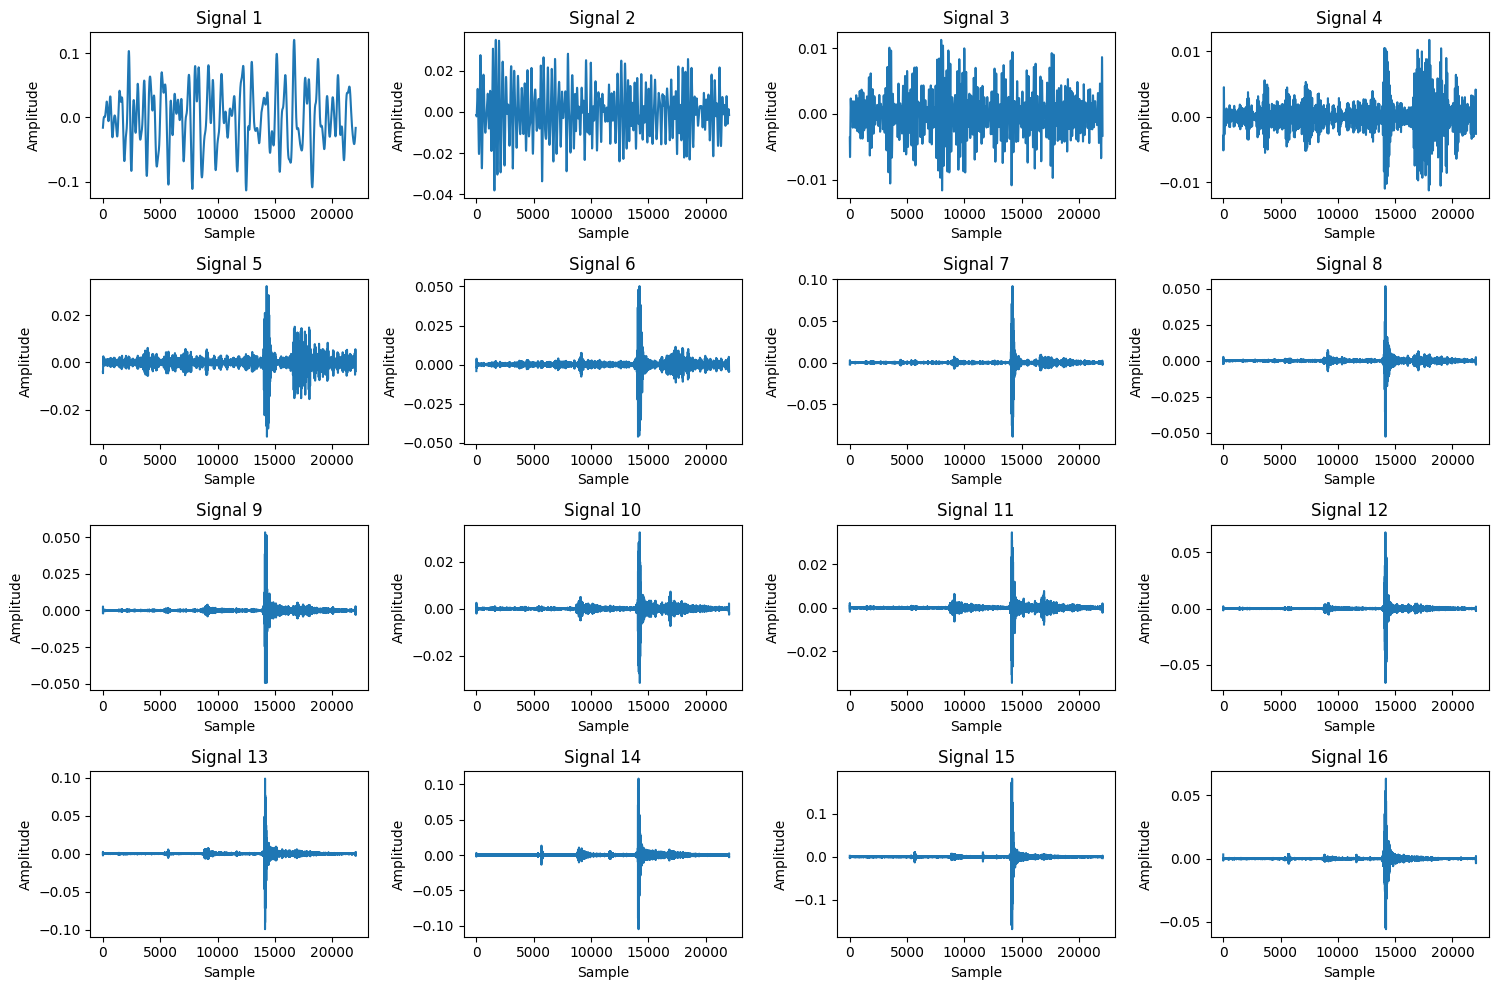

In [2]:
# Use of filterbanks   

# Load audio to filter ---------------
audio_path    = ".."+"/sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)
# Chop audio ------------------------
size = sr // 2
audio = audio[sr*2:sr*2 + size]
print("og audio")
display(Audio(audio, rate=sr))
audio = torch.tensor(audio).float()
# Create filterbank -----------------      
N_filter_bank = 16
erb_bank = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(size, sr, N_filter_bank, 20, sr // 2)
# Apply filterbank ------------------
subbands_signal = erb_bank.generate_subbands(audio)[1:-1, :]

def plot_signals(matrix):
    num_signals = matrix.shape[0]
    fig, axes = plt.subplots(4, 4, figsize=(15, 10))
    
    for i in range(num_signals):
        row = i // 4
        col = i % 4
        axes[row, col].plot(matrix[i].detach().cpu().numpy())
        axes[row, col].set_title(f'Signal {i+1}')
        axes[row, col].set_xlabel('Sample')
        axes[row, col].set_ylabel('Amplitude')

    # Hide any unused subplots
    for i in range(num_signals, 16):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

plot_signals(subbands_signal)

from IPython.display import Audio, display, HTML

# Generate HTML for a 4x4 matrix of playable audios
html_code = "<table style='width:100%; border-spacing:10px;'>"

for i in range(4):
    html_code += "<tr>"
    for j in range(4):
        index = i * 4 + j
        if index < len(subbands_signal):
            # Embed each audio widget in a cell
            audio_html = Audio(subbands_signal[index].detach().cpu().numpy(), rate=sr)._repr_html_()
            html_code += f"<td style='text-align:center; padding:10px;'>{audio_html}<br>Subband {index+1}</td>"
        else:
            # Empty cell if no audio is left
            html_code += "<td></td>"
    html_code += "</tr>"

html_code += "</table>"

# Display the matrix
display(HTML(html_code))

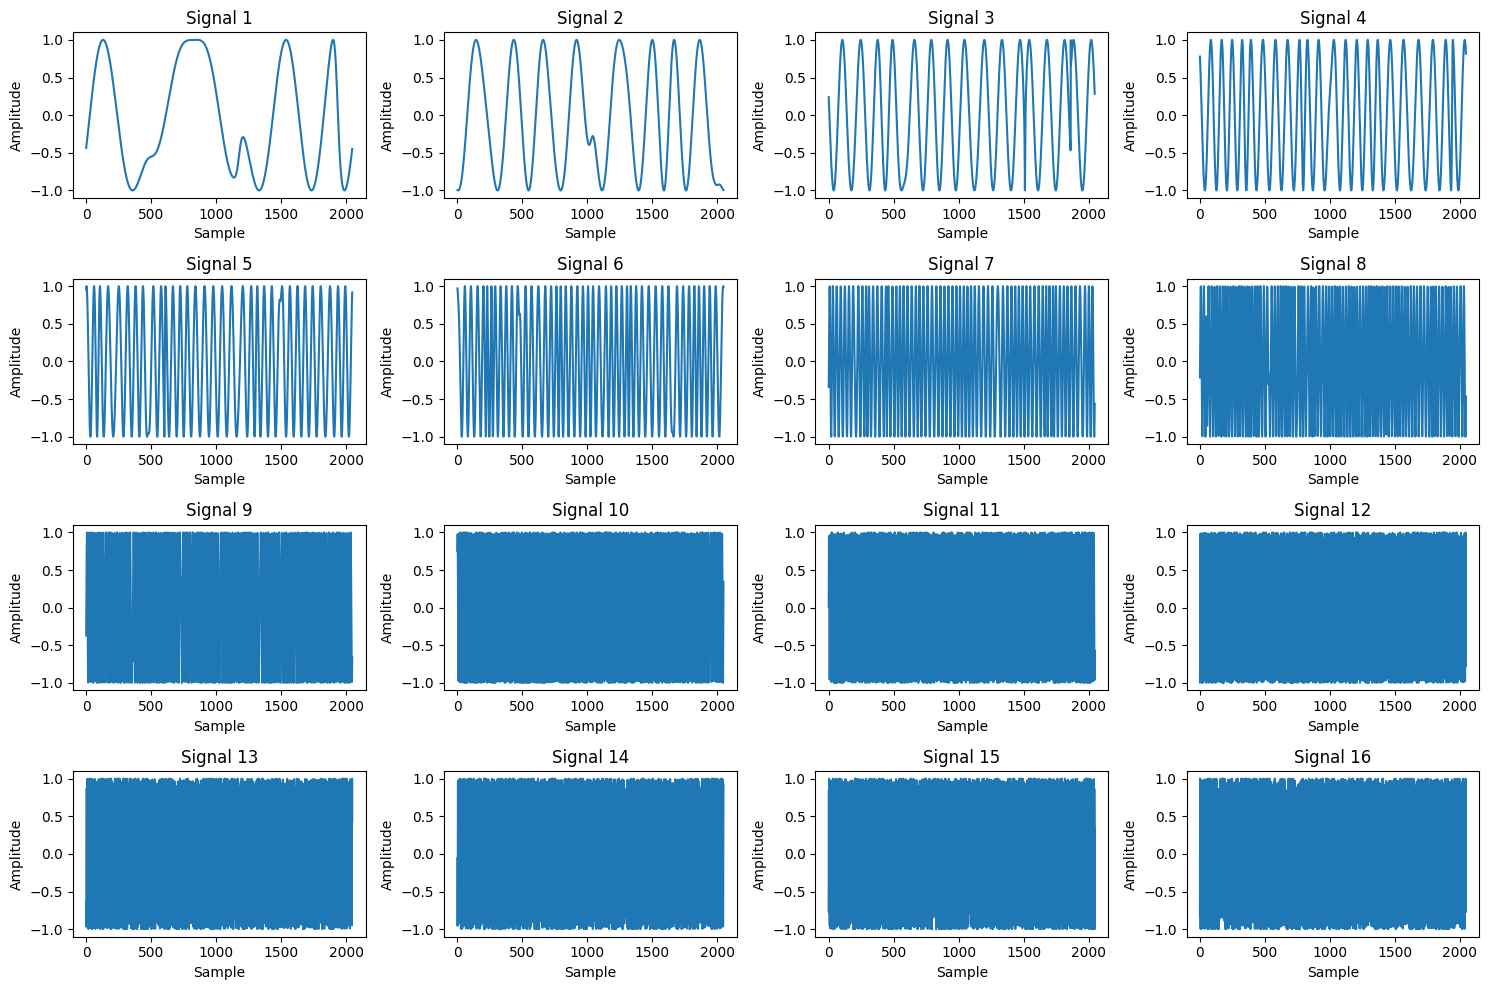

In [3]:
# Creation of seeds

seed = ddsp_textures.auxiliar.seeds.seed_maker(2048, 44100, N_filter_bank)
plot_signals(seed)

from IPython.display import Audio, display, HTML

# Generate HTML for a 4x4 matrix of playable audios
html_code = "<table style='width:100%; border-spacing:10px;'>"

for i in range(4):
    html_code += "<tr>"
    for j in range(4):
        index = i * 4 + j
        if index < len(subbands_signal):
            # Embed each audio widget in a cell
            audio_html = Audio(seed[i].detach().cpu().numpy(), rate=sr)
            html_code += f"<td style='text-align:center; padding:10px;'>{audio_html}<br>Subband {index+1}</td>"
        else:
            # Empty cell if no audio is left
            html_code += "<td></td>"
    html_code += "</tr>"

html_code += "</table>"


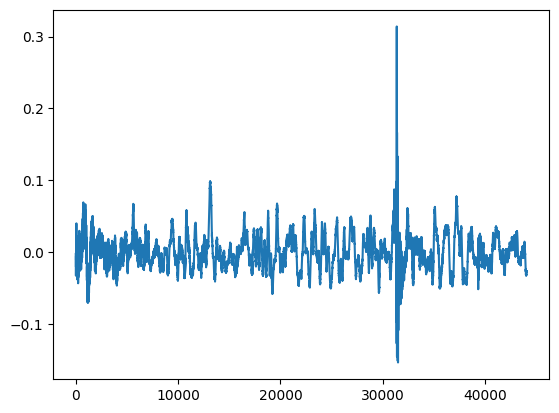

1. Feature using features_freqavg_freqstd
Frequency average: 0.7942098379135132
Frequency standard deviation: 0.8251842260360718


2. Feature using features_freqavg_rate
Frequency average: 0.7942098379135132
Rate: 0.20000000298023224
(Such rate can be interpreted as 1.0000000149011612 events in a second)


In [4]:
# Feature computation

# Load audio to filter -----------------------------------
audio_path    = ".."+"/sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)
import numpy as np
lol = np.random.randint(0, len(audio) - sr)
segment  = audio[lol:lol+ sr]
#plot segment
plt.plot(segment)
plt.show()
#play segment
display(Audio(segment, rate=sr))
#numpy to tensor
segment = torch.tensor(segment).float()
# Feature computation for a single segment ----------------
print("1. Feature using features_freqavg_freqstd")
freqavg, freqstd = ddsp_textures.auxiliar.features.features_freqavg_freqstd(segment, sr, _)
print(f"Frequency average: {freqavg}")
print(f"Frequency standard deviation: {freqstd}")
print("\n")
print("2. Feature using features_freqavg_rate")
rate = ddsp_textures.auxiliar.features.features_rate(segment, sr, _)
print(f"Frequency average: {freqavg}")
print(f"Rate: {rate}")
print("(Such rate can be interpreted as "+str(float(rate)*5)+" events in a second)")


In [5]:
# Feature computation in batches
import torch
from torch.utils.data import DataLoader, Dataset
import librosa

# Load audio to filter -----------------------------------
audio_path = "../sounds/fire_sounds/fire.wav"
sr = 44100
audio, _ = librosa.load(audio_path, sr=sr)

# Create a custom dataset for audio segments
class AudioSegmentDataset(Dataset):
    def __init__(self, audio, segment_length, max_segments):
        self.audio = audio
        self.segment_length = segment_length
        self.segments = self._create_segments(max_segments)

    def _create_segments(self, max_segments):
        segments = []
        total_segments = (len(self.audio) - self.segment_length) // self.segment_length + 1
        max_segments = min(max_segments, total_segments)
        for i in range(max_segments):
            start = i * self.segment_length
            end = start + self.segment_length
            segment = self.audio[start:end]
            segments.append(segment)
        return segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return torch.tensor(self.segments[idx], dtype=torch.float32)

# Define segment length (e.g., 1 second of audio)
segment_length = sr  # 1 second

# Set the maximum number of segments to be used in the dataset
max_segments = 10  # Adjust this value as needed

# Create the dataset
dataset = AudioSegmentDataset(audio, segment_length, max_segments)

# Create a DataLoader for batching
batch_size = 2  # Adjust as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Compute features for batches
i=0
for batch in dataloader:
    # Assuming batch is of shape (batch_size, segment_length)
    mean_std_features  = ddsp_textures.auxiliar.features.batch_features_freqavg_freqstd(batch, sr, _)
    freq_rate_features = ddsp_textures.auxiliar.features.batch_features_rate(batch, sr, _)
    
    # Print or process the results as needed
    print("Batch number: ", i)
    print("Mean and Std Dev features: ", mean_std_features)
    print("Rate features:", freq_rate_features, "\n")
    i+=1

Batch number:  0
Mean and Std Dev features:  tensor([[0.8419, 0.8568],
        [0.7602, 0.8352]])
Rate features: tensor([0.6000, 1.3622]) 

Batch number:  1
Mean and Std Dev features:  tensor([[0.8320, 0.8479],
        [0.8145, 0.8454]])
Rate features: tensor([0.2000, 0.8372]) 

Batch number:  2
Mean and Std Dev features:  tensor([[0.7948, 0.8371],
        [0.7783, 0.8310]])
Rate features: tensor([0.2000, 0.5750]) 

Batch number:  3
Mean and Std Dev features:  tensor([[0.8416, 0.8603],
        [0.8216, 0.8421]])
Rate features: tensor([0.4004, 0.4004]) 

Batch number:  4
Mean and Std Dev features:  tensor([[0.7588, 0.8284],
        [0.8780, 0.8615]])
Rate features: tensor([3.2830, 0.4000]) 



In [6]:
# Use of configuration

json_file_path = "config_template_TexEnv.json"
parameters = ddsp_textures.auxiliar.configuration.model_json_to_parameters(json_file_path)

for key, value in parameters.items():
    print(f"{key}: {value}")

NameError: name 'batch_statistics_loss_stems' is not defined

In [ ]:
# Checking if the name of the trained models folders work

# Assuming there is nothing in the folder trained_models this should print model_01
print(ddsp_textures.auxiliar.configuration.get_next_model_folder("../trained_models/"))
# Create folder model_01 in "../trained_models/"
os.makedirs("../trained_models/model_01")
# Assuming there is a folder model_01 in the folder trained_models this should print model_02
print(ddsp_textures.auxiliar.configuration.get_next_model_folder("../trained_models/"))
# Delete the folder created
os.rmdir("../trained_models/model_01")

model_01
model_02
